<a href="https://colab.research.google.com/github/Madhavmurari/ML-Projects/blob/main/credit_card_fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Credit Card Fraud Detection**

Credit card fraud is a major financial crime that affects millions of people worldwide. Detecting fraudulent transactions is crucial for minimizing losses and protecting customers. In this project, we will use machine learning techniques to identify potentially fraudulent credit card transactions using a real-world dataset.

## **Objective**

The main objective of this project is to build and evaluate models that can distinguish between legitimate and fraudulent credit card transactions. We will perform exploratory data analysis, preprocess the data, and experiment with various algorithms to achieve accurate fraud detection.

## **Dataset**

The dataset used in this project contains transactions made by European cardholders in September 2013. It presents transactions that occurred over two days and contains 284,807 records, with only 492 cases of fraud (highly imbalanced dataset). Most features are the result of a PCA transformation, except for 'Time', 'Amount', and 'Class' (where 'Class' is the target variable: 1 for fraud, 0 for normal).

Let's start by importing the necessary libraries.

#**Importing Libraries**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import iqr
import seaborn as sns
sns.set()

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,IsolationForest,VotingClassifier
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix,roc_curve,roc_auc_score,classification_report
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.cluster import MiniBatchKMeans

from tensorflow.keras.models import Model,Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input,Dense,BatchNormalization,Dropout
from tensorflow.keras.optimizers import Adam

from scipy.spatial.distance import euclidean
from imblearn.over_sampling import SMOTE
import random
import tensorflow as tf

from tensorflow.keras.utils import plot_model
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from mpl_toolkits.mplot3d import Axes3D

import warnings
warnings.filterwarnings('ignore')



# **Exploratory Data Analysis**

In [11]:
df=pd.read_csv('/content/creditcard.csv')

In [12]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [13]:
df.shape

(284807, 31)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28


- **Shape:** The dataset contains **284,807 rows** and **31 columns**.
- **Columns:** There are 30 features of type `float64` and 1 target variable (`Class`) of type `int64`.
- **Features:** Most columns (`V1` to `V28`) are anonymized principal components from a PCA transformation, plus `Time`, `Amount`, and `Class`.
- **Completeness:** There are **no missing values** in any column; all 284,807 entries are non-null.
- **Memory Usage:** The DataFrame uses approximately 67.4 MB of memory.
- **Target:** The `Class` column is the label — `0` for normal transactions and `1` for fraudulent transactions.

**Summary:**  
The dataset is clean, with no missing values or type inconsistencies. This completeness allows us to proceed directly with data exploration and preprocessing without worrying about imputation or type conversion. Given the anonymized nature of most features, domain-specific interpretations are limited, but standard statistical and machine learning techniques can be effectively applied.

In [15]:
#number of Dublicate Value
df.duplicated().sum()

np.int64(1081)

There is 1081 dublicate value. We we handle it in preprocessing.

In [16]:
df[df['Class']==1].describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
Time,492.0,80746.81,47835.37,406.00,41241.50,75568.50,128483.00,170348.00
V1,492.0,-4.77,6.78,-30.55,-6.04,-2.34,-0.42,2.13
V2,492.0,3.62,4.29,-8.40,1.19,2.72,4.97,22.06
V3,492.0,-7.03,7.11,-31.10,-8.64,-5.08,-2.28,2.25
V4,492.0,4.54,2.87,-1.31,2.37,4.18,6.35,12.11
V5,492.0,-3.15,5.37,-22.11,-4.79,-1.52,0.21,11.10
V6,492.0,-1.40,1.86,-6.41,-2.50,-1.42,-0.41,6.47
V7,492.0,-5.57,7.21,-43.56,-7.97,-3.03,-0.95,5.80
V8,492.0,0.57,6.80,-41.04,-0.20,0.62,1.76,20.01
V9,492.0,-2.58,2.50,-13.43,-3.87,-2.21,-0.79,3.35



- **Sample Size:** There are 492 fraudulent transactions in the dataset.
- **Transaction Amount:**
  - The average amount for frauds is \$122.21.
  - The median is much lower at \$9.25, indicating most fraudulent transactions are for small amounts.
  - There are a few very large fraudulent transactions, with the maximum reaching \$2,125.87.
- **Time:** Fraudulent transactions occur throughout the entire time span of the data; there is no strong clustering at a specific period.
- **Feature Patterns:**
  - Most PCA components (V1, V3, V5, V7, V9, V10, V12, V14, V16, V17, V18) have negative means, suggesting specific latent patterns associated with fraud.
  - A few components (V2, V4, V11, V19, V20, V21) have positive means, which may also be characteristic of fraud cases.
  - Many features show a large standard deviation and wide range (e.g., V7, V8, V21), reflecting high variability among fraud transactions.
- **Class:** All rows in this summary have `Class = 1` (fraud), as expected.

**Summary:**  
Fraudulent transactions are generally for low amounts but can occasionally be very large. The features derived from PCA show distinct statistical patterns (often negative means) compared to what is observed in typical, non-fraudulent transactions. These feature distributions and their variability can be crucial for machine learning models to distinguish fraud from normal activity.

In [17]:
df.groupby('Class')['Amount'].describe().round(2).T

Class,0,1
count,284315.00,492.00
mean,88.29,122.21
std,250.11,256.68
min,0.00,0.00
25%,5.65,1.00
50%,22.00,9.25
75%,77.05,105.89
max,25691.16,2125.87


**Key Observations:**
- **Fraudulent transactions have a higher average amount (\$122.21) than legitimate ones (\$88.29).**
- **The median and lower quartile for frauds are smaller,** showing that most frauds are for small amounts, but the upper quartile and mean are much higher, so a minority of frauds involve large sums.
- **Maximum transaction amount for legitimate transactions is much greater (\$25,691.16),** but fraudulent transactions can still reach very high values (\$2,125.87).
- **Overall:** Fraudulent transactions are typically small, but the presence of large-amount frauds increases the mean. This reflects a pattern where fraudsters frequently attempt many small transactions, but occasionally attempt high-value ones as well.

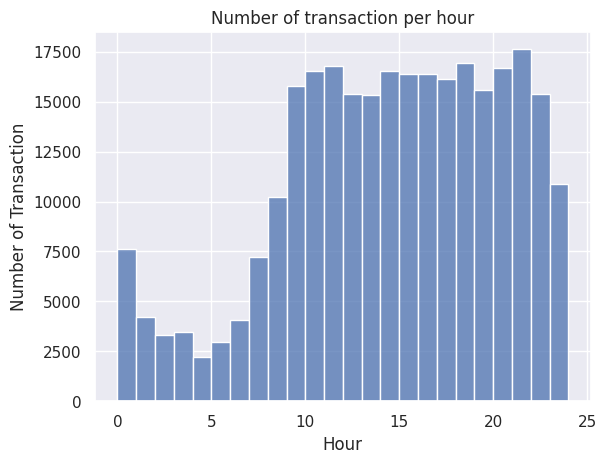

In [ ]:
df['Hour']=(df['Time']/3600)%24
sns.histplot(data=df, x='Hour',bins=24,kde=False)
plt.xlabel('Hour')
plt.ylabel('Number of Transaction')
plt.title('Number of transaction per hour')
plt.show()

##Hourly Transaction Distribution

- **Peak Hours (9 AM – 10 PM):**
  - Majority of transactions occur during the day and early evening, aligning with normal business and activity hours.

- **Low Activity (12 AM – 6 AM):**
  - Noticeably fewer transactions, likely due to users being inactive during nighttime.

- **Insights:**
  - Transactions outside typical hours (e.g., 2–5 AM) may indicate unusual behavior and could be valuable in detecting fraud.

In [ ]:
df.drop('Hour',axis=1,inplace=True) #Deleting hour Column

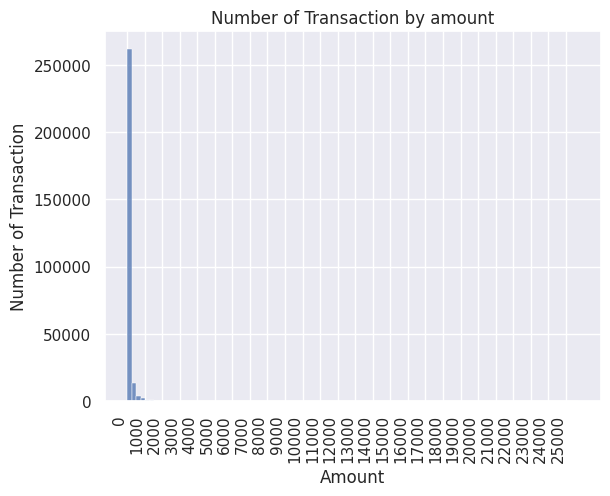

In [ ]:
sns.histplot(data=df,x='Amount',bins=100,kde=False)
plt.xticks(range(0,26000,1000),rotation=90,ha='right')
plt.title('Number of Transaction by amount')
plt.xlabel('Amount')
plt.ylabel('Number of Transaction')
plt.show()

In [ ]:
#Only V column for histogram purpose
V=['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28']

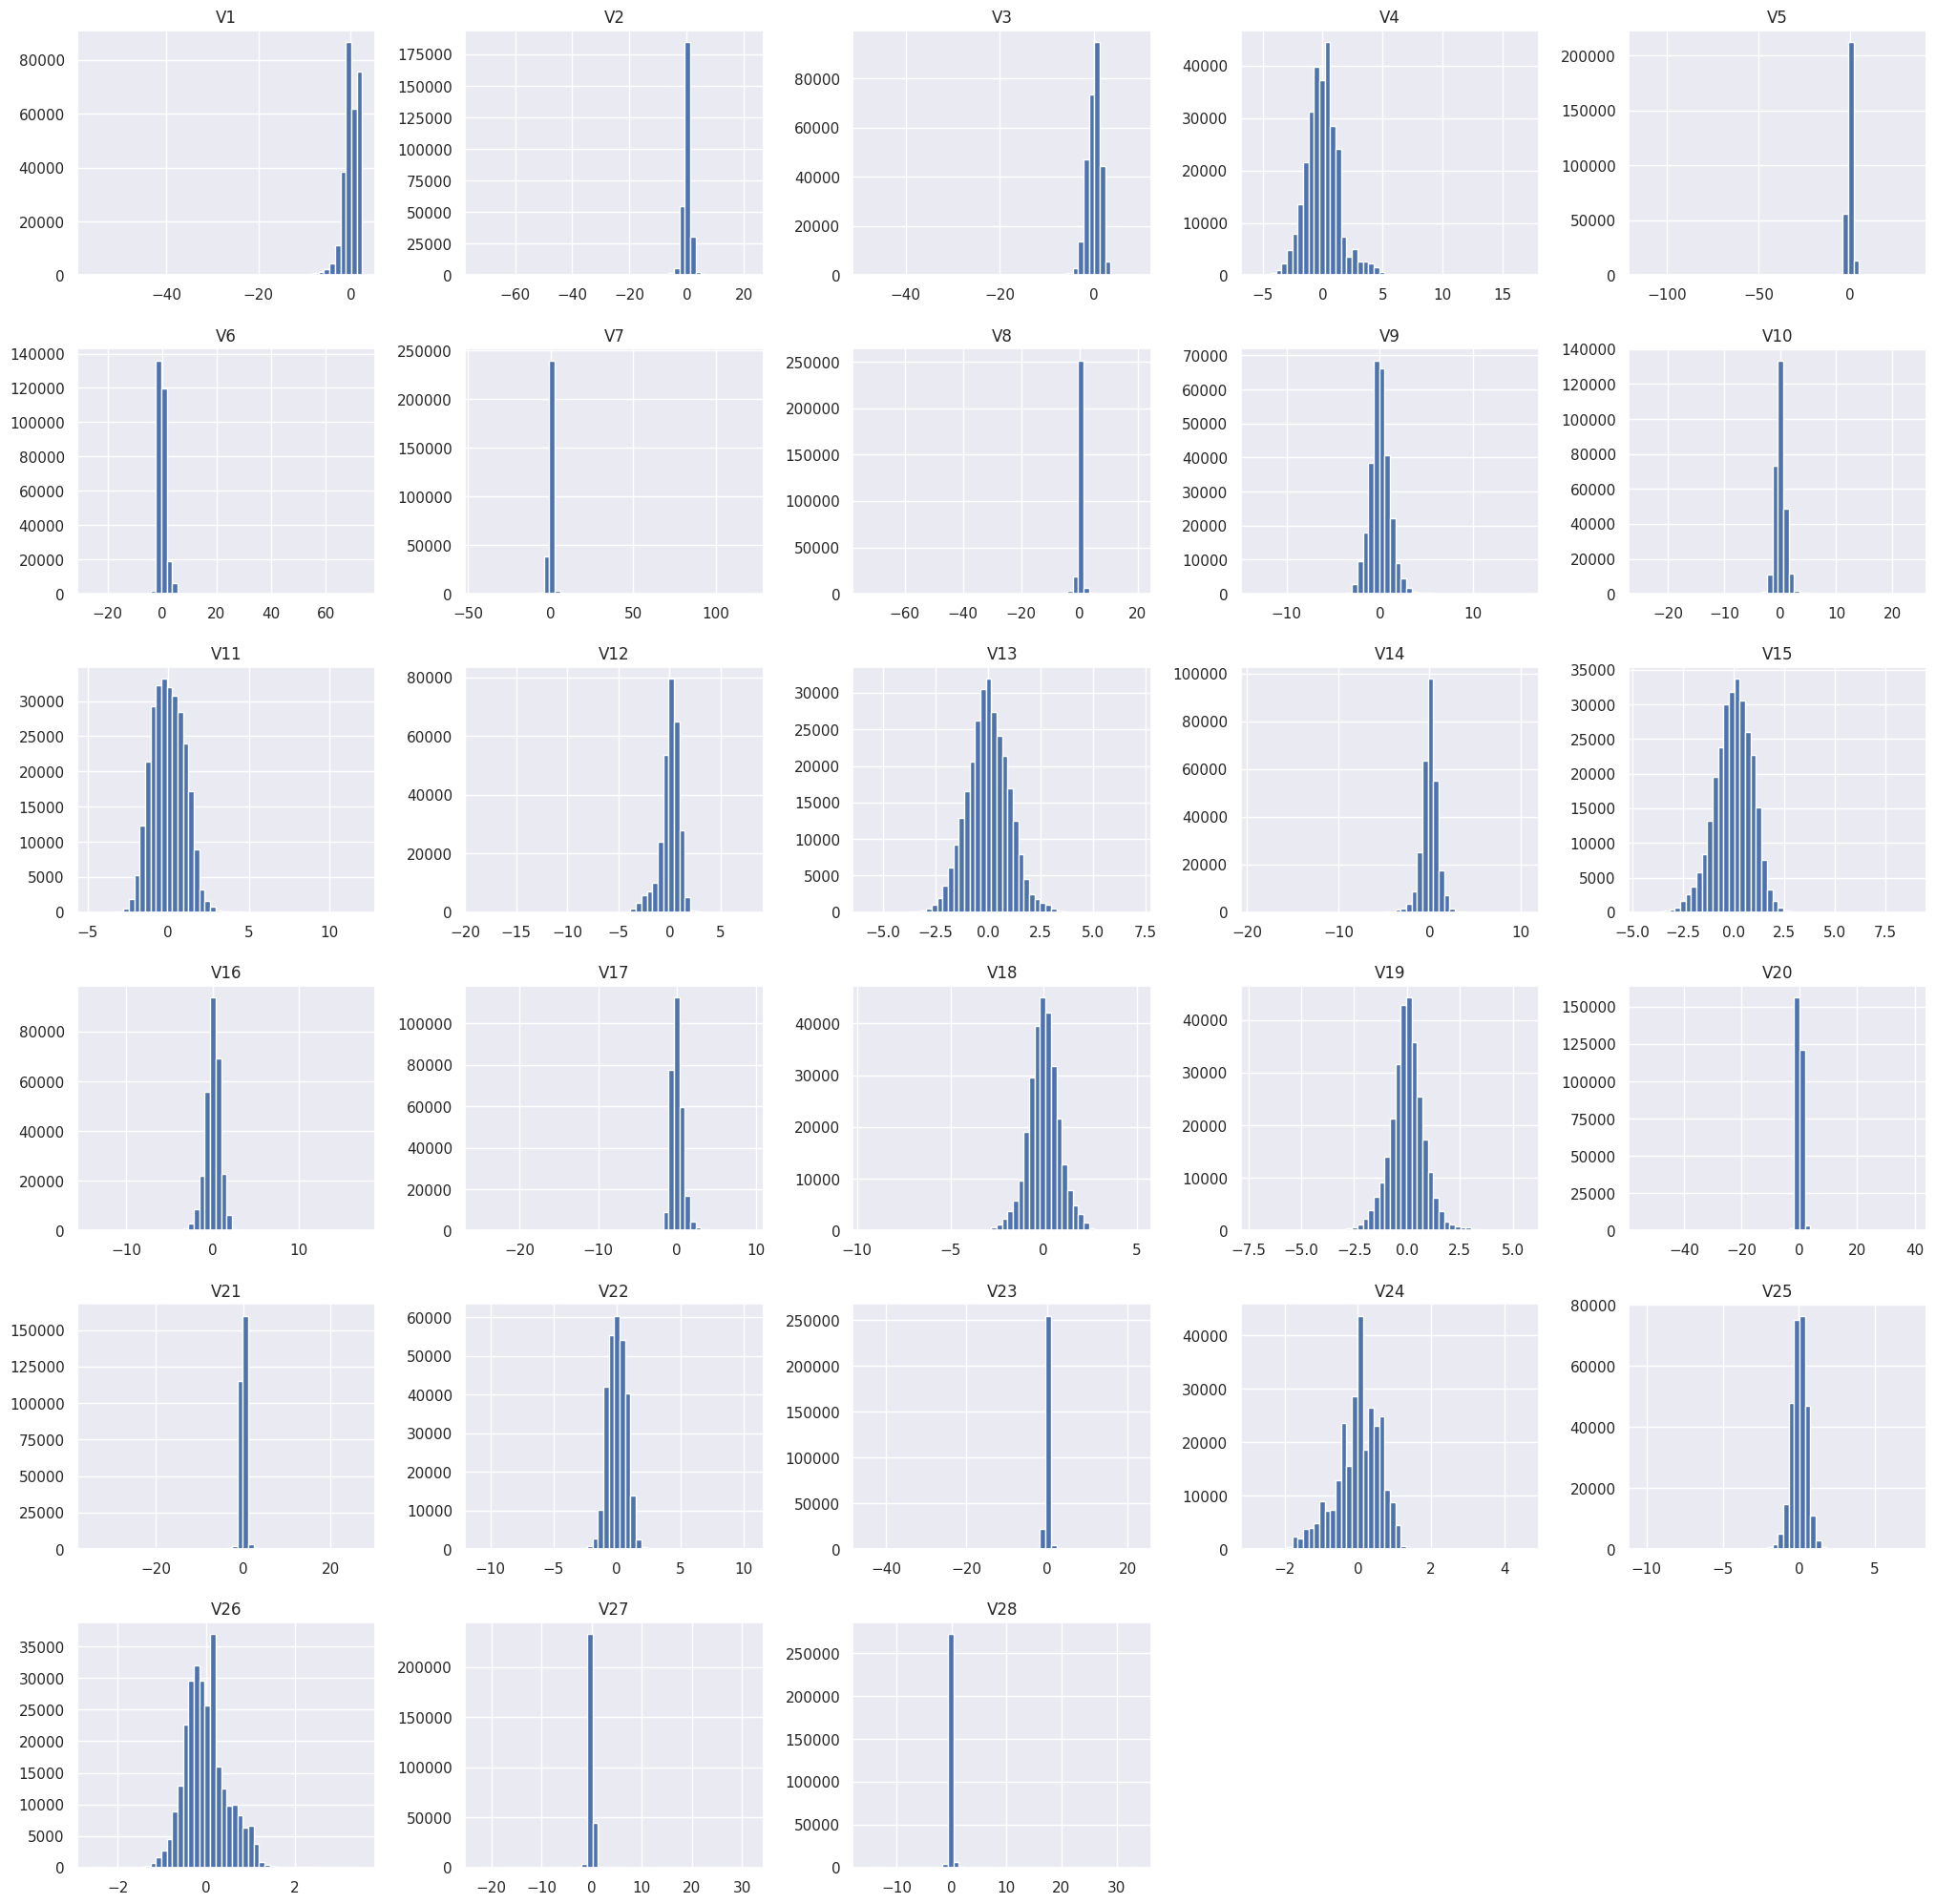

In [ ]:
df[V].hist(figsize=(25,25),bins=50)  # Histogram for each V column
plt.show()

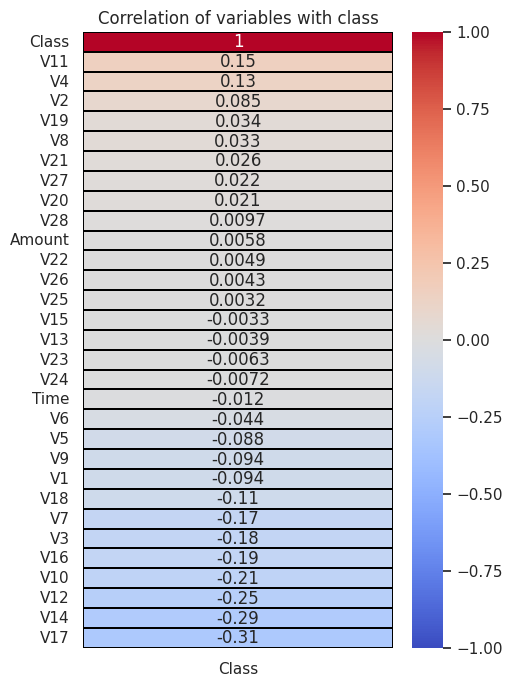

In [ ]:
plt.figure(figsize=(5,8))
sns.heatmap(df.corr()['Class'].sort_values(ascending=False).to_frame(),cmap='coolwarm',
            annot=True,vmin=-1,vmax=1,linewidths=0.3,linecolor='black')
plt.title('Correlation of variables with class')
plt.show()

In [ ]:
df['Hour']=(df['Time']/3600)%24

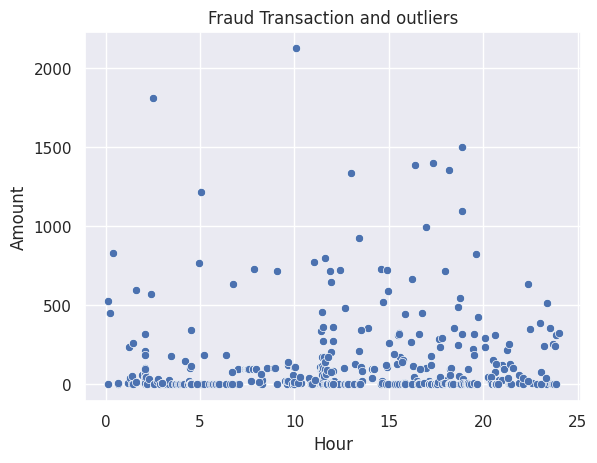

In [ ]:
sns.scatterplot(x='Hour',y='Amount',data=df[df['Class']==1])
plt.title('Fraud Transaction and outliers')
plt.show()

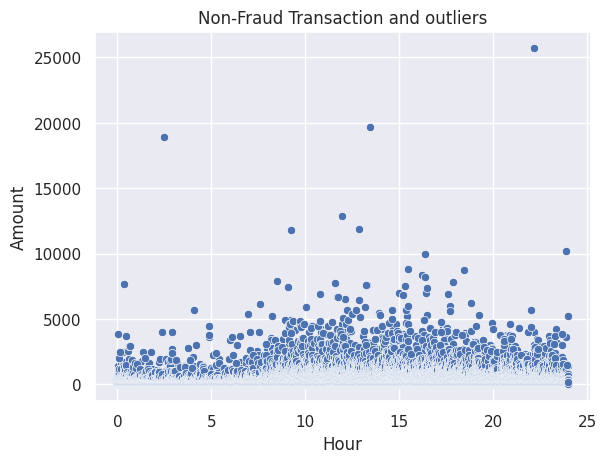

In [ ]:
sns.scatterplot(x='Hour',y='Amount',data=df[df['Class']==0])
plt.title('Non-Fraud Transaction and outliers')
plt.show()

In [ ]:
df=df.drop('Hour',axis=1)

In [ ]:

iqr_value=iqr(df['Amount'])
lower_bound=np.quantile(df['Amount'],0.25)-1.5*iqr_value
upper_bound=np.quantile(df['Amount'],0.75)+1.5*iqr_value
# filter=(df['Amount']<lower_bound | df['Amount']>upper_bound)
filter = (df['Amount'] < lower_bound) | (df['Amount'] > upper_bound)
print('Total Outlier',df[filter]['Amount'].count())
print('Fraud Outlier',df[filter & (df['Class']==1)]['Amount'].count())
print('Non-Fraud Outlier',df[filter & (df['Class']==0)]['Amount'].count())

Total Outlier 31685
Fraud Outlier 87
Non-Fraud Outlier 31598


Statistical Analysis

In [ ]:
Percentile=np.array([2.5,25.,50,75.,97.5])
cump_percentile=np.percentile(df['Amount'].values,Percentile)
print('Percentile',cump_percentile)

#Empirical Cumulative distibution function

Percentile [  0.76      5.6      22.       77.51    597.78625]


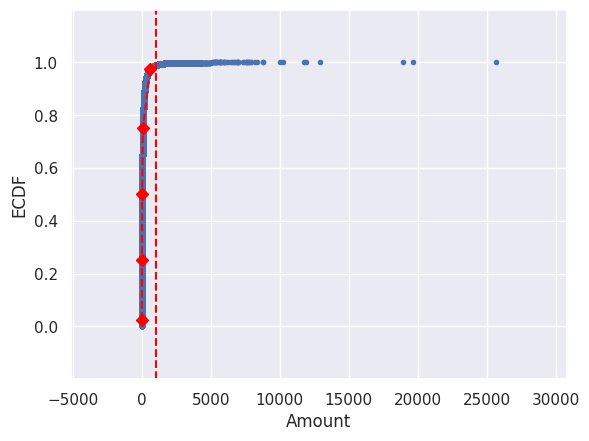

98.92% transaction less or equal to 1000 


In [ ]:
x=np.sort(df['Amount'])
y=np.arange(1,len(x)+1)/len(x)

fig,ax=plt.subplots()
ax.plot(x,y,marker='.',linestyle='none')
ax.axvline(x=1000,color='red',linestyle='--')
ax.set_xlabel('Amount')
ax.set_ylabel('ECDF')
ax.plot(cump_percentile, Percentile/100 ,marker='D',color='red',linestyle='--')
ax.margins(0.2)
plt.show()

smaller_1000=df['Amount'][df['Amount']<1000].count() /df['Amount'].count()

print(f"{smaller_1000:0.2%} transaction less or equal to 1000 ")

# **Preprocessing**

In [ ]:
#Drop the dublicate Value
df=df.drop_duplicates()

#**Machine Learning**

In [ ]:
#All fraud and 5000 non-fraud data
fraud=df[df['Class']==1]
non_fraud=df[df['Class']==0].sample(n=5000, random_state=42)
df=pd.concat([fraud,non_fraud])

In [ ]:
#Saperating the dependent and independent variable
X=df.iloc[:,:-1]
y=df.iloc[:,-1]

In [ ]:
#Train test split

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42)

print('Size of X_train',X_train.shape)
print('Size of X_test',X_test.shape)
print('Size of y_train',y_train.shape)
print('Size of y_test',y_test.shape)

print('Number of fraud in the train dataset before SMOTE',y_train[y_train==1].count())
print('Number of non-fraud in the train dataset before SMOTE',y_train[y_train==0].count())
print('Number of fraud in the test dataset',y_test[y_test==1].count())
print('Number of non-fraud in the test dataset',y_test[y_test==0].count())

Size of X_train (3831, 30)
Size of X_test (1642, 30)
Size of y_train (3831,)
Size of y_test (1642,)
Number of fraud in the train dataset before SMOTE 304
Number of non-fraud in the train dataset before SMOTE 3527
Number of fraud in the test dataset 169
Number of non-fraud in the test dataset 1473


**Logistic Regression**

In [ ]:
smote=SMOTE(random_state=42)
X_res,y_res=smote.fit_resample(X_train,y_train)
lr=LogisticRegression(solver='liblinear',random_state=42)
lr.fit(X_res,y_res)
y_pred=lr.predict(X_test)


In [ ]:
print('The shape of the X_train data after SMOTE',X_res.shape)
print('The shape of the y_train data after SMOTE',y_res.shape)

print('Number of fraud data_point in train dataset',y_res[y_res==1].count())
print('Number of non-fraud data_point in train dataset',y_res[y_res==0].count())



The shape of the X_train data after SMOTE (7054, 30)
The shape of the y_train data after SMOTE (7054,)
Number of fraud data_point in train dataset 3527
Number of non-fraud data_point in train dataset 3527


In [ ]:
print('Classification report:\n',classification_report(y_test,y_pred))
print('Accuracy_score:',accuracy_score(y_test,y_pred))


Classification report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98      1473
           1       0.87      0.86      0.86       169

    accuracy                           0.97      1642
   macro avg       0.93      0.92      0.92      1642
weighted avg       0.97      0.97      0.97      1642

Accuracy_score: 0.9719853836784409


In [ ]:
def plot_confusion_matrix(cm):
  cm=cm[::-1]
  cm=pd.DataFrame(cm,columns=['pre0','pre1'],index=['true 1','true 0'])
  fig=ff.create_annotated_heatmap(z=cm.values,x=list(cm.columns),y=list(cm.index),colorscale='plasma',showscale=True,reversescale=True)
  fig.update_layout(width=400,height=400,title='Confusion matrix',font_size=16)
  fig.show()

In [ ]:
plot_confusion_matrix(cm=confusion_matrix(y_test,y_pred))

In [ ]:
#Hyperparameter Tuning
param_grid={
    'penalty':['l1','l2'],
    'C':[0.001,0.01,0.1,1,10,100]
}
grid_lr=GridSearchCV(lr,param_grid,cv=5,scoring='f1')
grid_lr.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=LogisticRegression(random_state=42, solver='liblinear'),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'penalty': ['l1', 'l2']},
             scoring='f1')

In [ ]:
grid_lr.best_params_

{'C': 0.1, 'penalty': 'l1'}

In [ ]:
lr=LogisticRegression(solver='liblinear',C=0.1,penalty='l1',random_state=42)
lr.fit(X_res,y_res)
y_pred_grid=lr.predict(X_test)

In [ ]:
print('Classification Report:\n',classification_report(y_test,y_pred_grid))
print('Accuracy Score',accuracy_score(y_test,y_pred_grid))

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      1473
           1       0.92      0.86      0.89       169

    accuracy                           0.98      1642
   macro avg       0.95      0.92      0.94      1642
weighted avg       0.98      0.98      0.98      1642

Accuracy Score 0.9774665042630938


In [ ]:
plot_confusion_matrix(cm=confusion_matrix(y_test,y_pred_grid))

**Random Forest**

In [ ]:
#Random Forest Classifier
rfc=RandomForestClassifier(random_state=42)
rfc.fit(X_res,y_res)
y_pred_rf=rfc.predict(X_test)


In [ ]:
print('Classification Report:\n',classification_report(y_test,y_pred_rf))
print('Accuracy Score',accuracy_score(y_test,y_pred_rf))

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1473
           1       0.97      0.86      0.91       169

    accuracy                           0.98      1642
   macro avg       0.98      0.93      0.95      1642
weighted avg       0.98      0.98      0.98      1642

Accuracy Score 0.9829476248477467


In [ ]:
plot_confusion_matrix(cm=confusion_matrix(y_test,y_pred_rf))

In [ ]:
param_grid={
    'n_estimators':[50,100,200],
    'max_depth':[10,20,30,None],
    'min_samples_split':[2,5,10],
    'class_weight':['balanced',{0:1,1:10}]
}
rfc_grid=GridSearchCV(estimator=rfc,
                      param_grid=param_grid,
                      cv=5,
                      n_jobs=1,
                      scoring='f1'
                      )
rfc_grid.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=1,
             param_grid={'class_weight': ['balanced', {0: 1, 1: 10}],
                         'max_depth': [10, 20, 30, None],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='f1')

In [ ]:
rfc_grid.best_params_

{'class_weight': {0: 1, 1: 10},
 'max_depth': 10,
 'min_samples_split': 5,
 'n_estimators': 50}

In [ ]:
rfc=RandomForestClassifier(
    n_estimators=50,
    max_depth=10,
    min_samples_split=5,
    class_weight={0:1,1:10},
    random_state=42
)
rfc.fit(X_res,y_res)
y_pred_rfc=rfc.predict(X_test)

In [ ]:
print('Classification Report:\n',classification_report(y_test,y_pred_rfc))
print('Accuracy Score',accuracy_score(y_test,y_pred_rfc))

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1473
           1       0.89      0.87      0.88       169

    accuracy                           0.98      1642
   macro avg       0.94      0.93      0.93      1642
weighted avg       0.98      0.98      0.98      1642

Accuracy Score 0.9756394640682094


In [ ]:
plot_confusion_matrix(cm=confusion_matrix(y_test,y_pred_rfc))

**Deep Learning**

In [ ]:
#Normalised the data
scaler=StandardScaler()
X_train_dp=scaler.fit_transform(X_train)
X_test_dp=scaler.transform(X_test)

#Set the seed

tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

model=tf.keras.Sequential([
    tf.keras.layers.Dense(24,input_shape=(30,),activation='sigmoid'),

    tf.keras.layers.Dense(16,activation='sigmoid'),
    tf.keras.layers.Dense(1,activation='sigmoid')
])
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

model.fit(X_train_dp,y_train,epochs=15,batch_size=32,validation_data=(X_test_dp,y_test))

score=model.evaluate(X_test_dp,y_test)

print('Loss:',score[0])
print('Accuracy:',score[1])

y_pred_dp=model.predict(X_test_dp)
y_pred_class=(y_pred_dp>0.5).astype('int32')





Epoch 1/15
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9163 - loss: 0.3713 - val_accuracy: 0.8971 - val_loss: 0.2615
Epoch 2/15
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9163 - loss: 0.2159 - val_accuracy: 0.8971 - val_loss: 0.1960
Epoch 3/15
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9192 - loss: 0.1581 - val_accuracy: 0.9635 - val_loss: 0.1434
Epoch 4/15
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9755 - loss: 0.1155 - val_accuracy: 0.9793 - val_loss: 0.1137
Epoch 5/15
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9824 - loss: 0.0918 - val_accuracy: 0.9805 - val_loss: 0.0984
Epoch 6/15
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9827 - loss: 0.0792 - val_accuracy: 0.9823 - val_loss: 0.0904
Epoch 7/15
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9826 - loss: 0.0718 - val_accuracy: 0.9836 - val_loss: 0.0860
Epoch 8/15
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9828 - loss: 0.0672 - val_accuracy: 0.

In [ ]:
print('Classification Report:\n',classification_report(y_test, y_pred_class))
print('Accuracy:',accuracy_score(y_test, y_pred_class))

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1473
           1       0.98      0.85      0.91       169

    accuracy                           0.98      1642
   macro avg       0.98      0.93      0.95      1642
weighted avg       0.98      0.98      0.98      1642

Accuracy: 0.9829476248477467


In [ ]:
plot_confusion_matrix(cm=confusion_matrix(y_test,y_pred_class))

**Use of Autoencoder**

In [ ]:
input_dim=X_train_dp.shape[1]
encoding_dim=64
#Encoder
input_layer=Input(shape=(input_dim,))
encoder_1=Dense(encoding_dim,activation='relu',activity_regularizer=regularizers.l1(10e-5))(input_layer)

encoder_2=Dense(int(encoding_dim/2),activation='relu')(encoder_1)

encoder_3=Dense(int(encoding_dim/4),activation='relu')(encoder_2)




#decoder



decoder_3=Dense(int(encoding_dim/4),activation='relu')(encoder_3)

decoder_2=Dense(int(encoding_dim/2),activation='relu')(decoder_3)

decoder_1=Dense(encoding_dim,activation='relu')(decoder_2)


output_layer=Dense(input_dim,activation='sigmoid')(decoder_1)
autoencoder=Model(inputs=input_layer,outputs=output_layer)



In [ ]:
# Assembling and Training Autoencoders
autoencoder.compile(optimizer='adam',loss='mean_squared_error')
history=autoencoder.fit(
    X_train_dp,X_train_dp,
    epochs=100,
    batch_size=256,
    shuffle=True,
    validation_split=0.2,
    verbose=1
)

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 1.6247 - val_loss: 1.5398
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5136 - val_loss: 1.4197
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.3897 - val_loss: 1.3198
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.3000 - val_loss: 1.2623
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.2466 - val_loss: 1.2231
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.2048 - val_loss: 1.1882
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1698 - val_loss: 1.1574
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1390 - val_loss: 1.1298
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.1113 - val_loss: 1.1047
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0863 - val_loss: 1.0818
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.0636 - val_loss: 1.0609
Epoch 12/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - los

In [ ]:
latent_model = Sequential()
latent_model.add(autoencoder.layers[0])
latent_model.add(autoencoder.layers[1])
latent_model.add(autoencoder.layers[2])
latent_model.add(autoencoder.layers[3])
latent_model.add(autoencoder.layers[4])


In [ ]:
X_train_encoded=latent_model.predict(X_train_dp)
X_test_encoded=latent_model.predict(X_test_dp)

120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [ ]:
print(X_train_encoded.shape)
print(X_test_encoded.shape)

(3831, 16)
(1642, 16)


In [ ]:
model_2=tf.keras.Sequential([
    tf.keras.layers.Dense(24,activation='sigmoid',input_shape=(X_test_encoded.shape[1],)),
    tf.keras.layers.Dense(16,activation='sigmoid'),
    tf.keras.layers.Dense(1,activation='sigmoid')
])
model_2.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])





In [ ]:
deep_history = model_2.fit(X_train_encoded, y_train,
                              epochs=100,
                              batch_size=256,
                              validation_data=(X_test_encoded, y_test),
                              verbose=1)

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.3645 - loss: 0.7058 - val_accuracy: 0.8971 - val_loss: 0.5845
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9162 - loss: 0.5456 - val_accuracy: 0.8971 - val_loss: 0.4740
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9162 - loss: 0.4394 - val_accuracy: 0.8971 - val_loss: 0.4070
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9162 - loss: 0.3742 - val_accuracy: 0.8971 - val_loss: 0.3685
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9162 - loss: 0.3356 - val_accuracy: 0.8971 - val_loss: 0.3469
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9162 - loss: 0.3129 - val_accuracy: 0.8971 - val_loss: 0.3345
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9162 - loss: 0.2991 - val_accuracy: 0.8971 - val_loss: 0.3268
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9162 - loss: 0.2902 - val_accuracy: 0.8971 - 

In [ ]:
# Forecasting Using the Deep Learning Model
y_pred_encode = model_2.predict(X_test_encoded)
y_pred_2 = (y_pred_encode > 0.5).astype(int)

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [ ]:
print("Classification Report:\n", classification_report(y_test, y_pred_2))
print("Accuracy: ", accuracy_score(y_test, y_pred_2))

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      1473
           1       0.94      0.74      0.83       169

    accuracy                           0.97      1642
   macro avg       0.96      0.87      0.91      1642
weighted avg       0.97      0.97      0.97      1642

Accuracy:  0.9683313032886723


In [ ]:
plot_confusion_matrix(cm=confusion_matrix(y_test,y_pred_2))